In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
from scipy.stats import cauchy

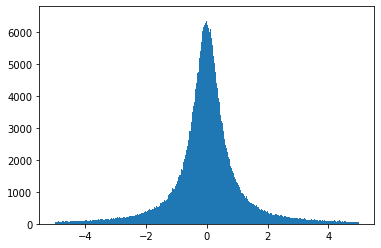

In [3]:
lor = cauchy.rvs(loc=0,scale=0.5,size=1000000)
    
plt.hist(lor,bins=1000,range=(-5,5));

In [4]:
w_0 = 462 # [GHz] Centre frequency

# THESE DIRECTLY RELATE TO THE SCALING FACTORS
sigma_short = 0.33 # [GHz] Timescale of minute
sigma_long = 0.66 # [GHz] Timescale of hours

laser_linewidth = 10000 # [Hz] maximum
laser_precision = 50*10**6 # [Hz] not sure what this means
spd_efficiency = 0.9 # worst case
spd_jitter = 100*10**-12 # [s]

tau_r = 900*10**-12 # [s] radiative lifetime
h_bar = 1.054571817*10**-34 # [J*s]
base_linewidth = h_bar/tau_r

In [77]:
def noise_generator(num_steps, window, scaling_factor):
    rand_vals = np.zeros(window)
    smooth_vals = np.zeros(window)
    smoother_vals = np.zeros(window)
    smoothist_vals = np.zeros(window)
    wandering = np.zeros(num_steps)
    for i in range(num_steps):
        rand_vals = np.roll(rand_vals,1)
        smooth_vals = np.roll(smooth_vals,1)
        smoother_vals = np.roll(smoother_vals,1)
        smoothist_vals = np.roll(smoothist_vals,1)
        rand_vals[0] = np.random.normal(0,1,1)
        smooth_vals[0] = np.sum(rand_vals)/window
        smoother_vals[0] = np.sum(smooth_vals)/window
        smoothist_vals[0] = np.sum(smoother_vals)/window
        wandering[i] = scaling_factor*np.sum(smoothist_vals)/window
    std = np.std(wandering)
    return wandering/std

1.0


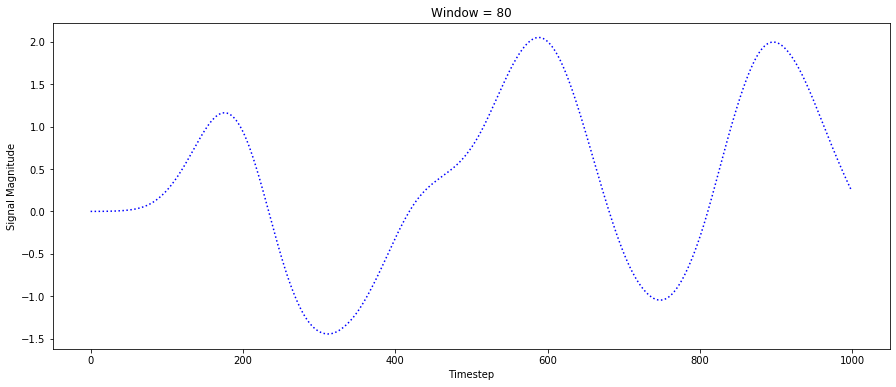

In [85]:
num_steps = 1000
window = 80
noise = noise_generator(num_steps,window,1)
print(np.std(noise))
times = np.arange(num_steps)
plt.rcParams['figure.figsize'] = [15, 6]
plt.title("Window = 80")
plt.xlabel("Timestep")
plt.ylabel("Signal Magnitude")
plt.plot(times,noise,linestyle=':',color='b')

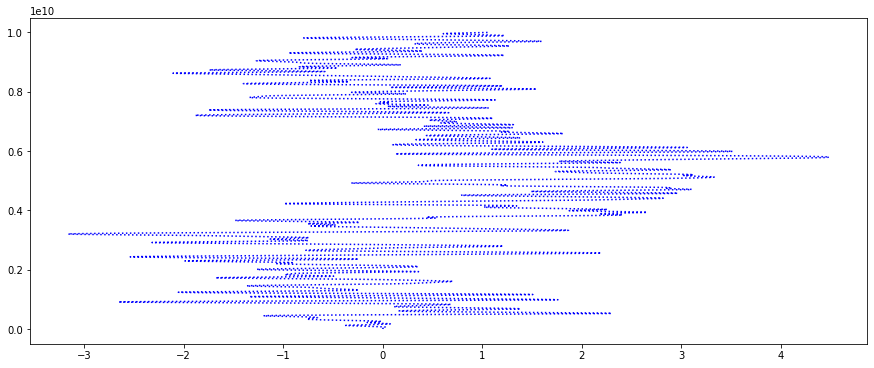

In [87]:
timestep = 10**-5 # [s]
num_steps = 10**5

wandering_1 = noise_generator(num_steps,500,0.5)
wandering_2 = noise_generator(num_steps,10000,1)
total = wandering_1 + wandering_2
times = np.arange(num_steps)/timestep

plt.plot(total,times,linestyle=':',color='b')
plt.rcParams['figure.figsize'] = [12, 24]

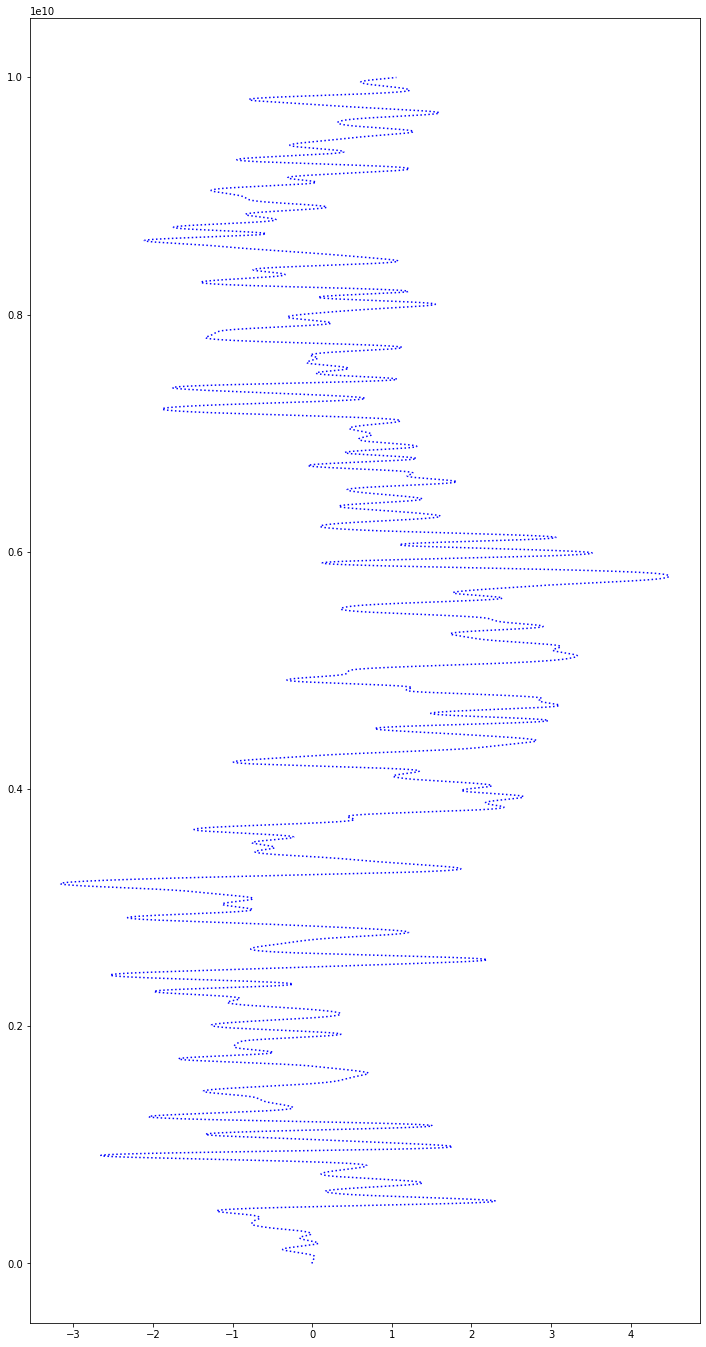

In [88]:
plt.plot(total,times,linestyle=':',color='b')
plt.rcParams['figure.figsize'] = [12, 15]

In [ ]:
lor = cauchy.rvs(loc=0,scale=0.3,size=1)
loc_1 = -1
loc_2 = 0
loc_3 = 1
def measure_point

In [ ]:
class Spectrum_Simulator:
        def __init__(self, centre_freq=0, base_linewidth=1):
            centre = centre_freq
            FWHM = base_linewidth
            num_noises = 0
            windows = []
            stds = []
            
        def add_noise(self, window, std):
            num_noises += 1
            windows.append(window)
            stds.append(std)
            
        def step(self, time):
            
        def measure_counts(target_freq, boundaries, time):
            
            
            

In [2]:
import numpy as np
from functools import reduce

def band_limited_noise(min_freq, max_freq, samples=44100, samplerate=44100):
    t = np.linspace(0, samples/samplerate, samples)
    freqs = np.arange(min_freq, max_freq+1, samples/samplerate)
    phases = np.random.rand(len(freqs))*2*np.pi
    signals = [np.sin(2*np.pi*freq*t + phase) for freq,phase in zip(freqs,phases)]
    signal = reduce(lambda a,b: a+b,signals)
    signal /= np.max(signal)
    return signal

In [17]:
y = band_limited_noise(10,1000,samples=100,samplerate=100)

In [18]:
print(y)

[ 0.07308773  0.11170841  0.55126    -0.12909617 -0.25501435 -0.39588901
  0.35735897  0.3893976  -0.11003225  0.03329458 -0.36875545  0.44845414
 -0.11905749  0.12183677 -0.03771187  0.33907539  0.00683164 -0.30329164
 -0.55877228 -0.22556754  0.30439291  0.21589852 -0.04398254  0.55124305
  0.29546931 -0.06717538 -0.32794264 -0.26138507 -0.24996497 -0.15351512
  0.39056584  0.14355565  0.4054294  -0.45857684  0.03350881 -0.07301564
 -0.11236927  0.35377645 -0.30252704 -0.53475822  0.08098442 -0.05800173
  0.57634775  0.05393165 -0.27374593 -0.04325617  0.10423084  0.68168084
  0.40359551  0.16350962 -0.05647215  0.35089649 -0.55940516  0.18143994
 -0.34525104 -0.11249451 -0.2651319  -0.50804399  0.18695069  0.30842166
 -0.16006882 -0.08587284 -0.07631706  0.37187375  0.07113893 -0.31078043
  0.01449994 -0.4977361   0.31217603  0.68955723  0.19834773 -0.09044174
  1.         -0.12654991  0.64745631  0.23936048  0.15284783  0.0479396
  0.04579911  0.16469733  0.16505294  0.07192002 -0.

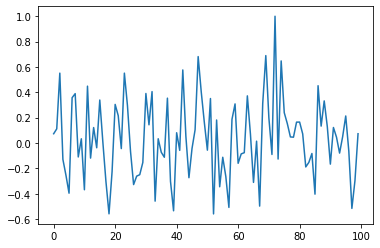

In [19]:
x = np.arange(0,100)
plt.plot(x,y)

In [21]:
from scipy import fft, ifft

C:\Users\adamg\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


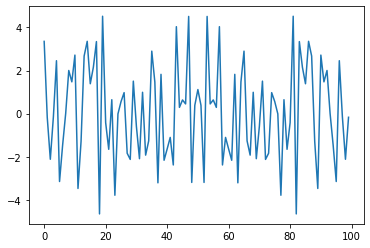

In [23]:
y = fft(y)
plt.plot(x,y)